In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [9]:
industries = [
    "Mining", "Construction", "Information Technology", "Pharmaceuticals", "Real Estate", "Hospitality", 
    "Energy", "Automotive", "Agriculture", "Telecommunications", "Transportation and Logistics", 
    "Manufacturing", "Biotechnology", "Consumer Goods"
]

genders = [
  "Male", "Female", "Non-binary"
]

gender_weighting = [
  0.49, 0.49, 0.02
]

class RandomDataGenerator:
  def __init__(self, num_people, num_preferences, num_questions):
    self.num_people = num_people
    self.num_preferences = num_preferences
    self.num_questions = num_questions
    self.df = pd.DataFrame()
  
  def create(self):
    ids = [i for i in range(0, self.num_people)]
    ids.extend(ids)
    self.df['ID'] = ids

    for i in range(0, self.num_people * 2):
      self.df.loc[i, [f'Preference {j+1}' for j in range(self.num_preferences)]] = 0
      specific_industries = random.sample(industries, random.randint(1,3))
      self.df.loc[i, 'Industry'] = ";".join(specific_industries)
      self.df.loc[i, [f'Rank {j+1}' for j in range(self.num_questions)]] = random.sample(range(1, 11), self.num_questions)
      self.df.loc[i, 'Gender'] = random.choices(genders, weights = gender_weighting, k = 1)[0]
      gender_preferences = [
        self.df.loc[i, 'Gender'], "No Preference"
      ]
      self.df.loc[i, 'Gender Preference'] = random.choices(gender_preferences, weights = [0.2,0.8], k = 1)[0]

    for i in range(0, self.num_people * 2):
      same_industry_gender = []
      same_industry = []
      diff_industry = []
      curr_industry = set(self.df.loc[i, 'Industry'].split(';'))

      start = 0
      stop = 0

      if i < 200:
        start = self.num_people
        stop = self.num_people * 2
      else:
        stop = self.num_people

      for j in range(start, stop):
        temp_industry = set(self.df.loc[j, 'Industry'].split(';'))
        if self.df.loc[i, 'Gender Preference'] != "No Preference":
          if len(temp_industry.intersection(curr_industry)) > 0 and self.df.loc[i, 'Gender Preference'] == self.df.loc[j, 'Gender']:
            same_industry_gender.append(j % self.num_people)
          elif len(temp_industry.intersection(curr_industry)) > 0:
            same_industry.append(j % self.num_people)
          else:
            diff_industry.append(j % self.num_people)
        else:
          if len(temp_industry.intersection(curr_industry)) > 0:
            same_industry_gender.append(j % self.num_people)
          else:
            same_industry.append(j % self.num_people)
      
      if len(same_industry_gender) < self.num_preferences:
        same_industry_gender.extend(same_industry[0:(self.num_preferences-len(same_industry_gender))])

      if len(same_industry_gender) < self.num_preferences:
        same_industry_gender.extend(diff_industry[0:(self.num_preferences-len(same_industry_gender))])

      self.df.loc[i, [f'Preference {j+1}' for j in range(self.num_preferences)]] = random.sample(same_industry_gender, self.num_preferences)

    for i in range(self.num_preferences):
      self.df[f'Preference {i+1}'] = self.df[f'Preference {i+1}'].astype(int)
    
    for i in range(self.num_questions):
      self.df[f'Rank {i+1}'] = self.df[f'Rank {i+1}'].astype(int)
  
  def export(self):
    mentor_df = self.df.iloc[:200,:]
    mentee_df = self.df.iloc[200:,:]
    return mentor_df, mentee_df

class MatchingAlgorithm:
  def __init__(self, mentor_df, mentee_df, num_preferences, num_questions, mentor_weight, mentee_weight):
    self.mentor_df = mentor_df
    self.mentee_df = mentee_df
    self.num_preferences = num_preferences
    self.num_questions = num_questions
    self.size = self.mentor_df.shape[0]
    self.width = self.mentor_df.shape[1]
    self.scores = np.zeros((self.size, self.size)) # row is mentor, column is mentee
    self.mentor_weight = mentor_weight / mentee_weight
    self.mentor_top_pref = self.mentor_df.iloc[:,1:1+self.num_preferences]
    self.mentee_top_pref = self.mentee_df.iloc[:,1:1+self.num_preferences]

  def create_pairs(self):
    self.concat_industry()
    self.calculate_scores()
    self.match_pairs()
    return self.pairs

  def concat_industry(self):
    self.mentor_df.iloc[:,1+self.num_preferences] = self.mentor_df.iloc[:,1+self.num_preferences].apply(lambda x: set(x.split(';')))
    self.mentee_df.iloc[:,1+self.num_preferences] = self.mentee_df.iloc[:,1+self.num_preferences].apply(lambda x: set(x.split(';')))

  def calculate_scores(self):
    # First add to the score based on mentor/mentee preferences
    for i in range(self.size):
      preferences = self.mentor_df.iloc[i, 1:self.num_preferences+1]
      for j, preference in enumerate(preferences):
        self.scores[i][preference] += self.num_preferences * self.mentor_weight * 100 - 100 * j

    for i in range(self.size):
      preferences = self.mentee_df.iloc[i, 1:self.num_preferences+1]
      for j, preference in enumerate(preferences):
        self.scores[preference][i] += self.num_preferences * 100 - 100 * j

    # Then see if any industries overlap and calculate residuals of quantitative questions
    temp_scores = np.zeros((self.size, self.size))

    for i in range(self.mentor_df.shape[0]):
      mentor_industries = self.mentor_df.iloc[i, 1 + self.num_preferences]
      mentor_gender = self.mentor_df.iloc[i,self.width-2]
      mentor_pref = self.mentor_df.iloc[i,self.width-1]
      for j in range(self.mentee_df.shape[0]):
        mentee_industries = self.mentee_df.iloc[j, 1 + self.num_preferences]
        mentee_gender = self.mentee_df.iloc[j,self.width-2]
        mentee_pref = self.mentee_df.iloc[j,self.width-1]
        industries = mentor_industries.intersection(mentee_industries)
        if len(industries) > 0 and mentor_pref == "No Preference" or mentor_pref == mentee_gender and mentee_pref == "No Preference" or mentee_pref == mentor_gender:
          temp_scores[i][j] += (10 * self.num_questions + 10 * np.sqrt(len(industries))) * 2
        elif len(industries) > 0:
          temp_scores[i][j] += 10 * self.num_questions + 10 * np.sqrt(len(industries))

    for i in range(self.mentor_df.shape[0]):
      for j in range(self.mentee_df.shape[0]):
        residual_sum = (10 - (self.mentor_df.iloc[i,2+self.num_preferences:self.width - 2] - self.mentee_df.iloc[j,2+self.num_preferences:self.width - 2]).abs()).sum()
        temp_scores[i][j] += residual_sum

    # Normalize the data to range from 0 to 99 and add to scores
    temp_scores = (temp_scores - temp_scores.min()) * 99 / (temp_scores.max() - temp_scores.min())    
    self.scores += temp_scores

    # Create array of mentor and mentee preferences based on the highest score
    self.mentor_preferences = np.zeros((self.size, self.size), dtype = int)
    self.mentee_preferences = np.zeros((self.size, self.size), dtype = int)

    for i in range(self.size):
      self.mentor_preferences[i] = self.scores[i].argsort()[::-1]
      self.mentee_preferences[i] = self.scores[:,i].argsort()[::-1]

  def match_pairs(self):
    self.mentor_preferences = self.mentor_preferences.tolist()
    self.mentee_preferences = self.mentee_preferences.tolist()

    free_mentors = list(range(self.size))
    pairs = {}
    mentor_proposals = dict.fromkeys(free_mentors, [])

    while free_mentors:
      mentor = free_mentors[0]
      mentor_pref = self.mentor_preferences[mentor]

      for mentee in mentor_pref:
        if mentee not in mentor_proposals[mentor]:
          mentor_proposals[mentor].append(mentee)

          if mentee not in pairs.values():
            pairs[mentor] = mentee
            free_mentors.remove(mentor)
            break

          else:
            current_mentor = next(m for m, v in pairs.items() if v == mentee)
            mentee_pref = self.mentee_preferences[mentee]

            if mentee_pref.index(mentor) < mentee_pref.index(current_mentor):
              pairs[mentor] = mentee
              free_mentors.remove(mentor)
              free_mentors.append(current_mentor)
              del pairs[current_mentor]
              break

    self.pairs = pairs

  # Calculate the number of top 10 choice matches
  def output_accuracy(self):
    mentor_matches = 0
    mentee_matches = 0
    for mentor, mentee in self.pairs.items():
      mentor_pref = self.mentor_top_pref.iloc[mentor,:].values.tolist()
      mentee_pref = self.mentee_top_pref.iloc[mentee,:].values.tolist()
      if mentee in mentor_pref:
        mentor_matches += 1
      if mentor in mentee_pref:
        mentee_matches += 1

    return (mentor_matches / self.size) , (mentee_matches / self.size)

In [13]:
%%capture output
mentor_data = []
mentee_data = []
weights = [1,1.05,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.45,1.5]

for weight in weights:
   temp_mentor_data = []
   temp_mentee_data = []

   for _ in range(5):
    rg = RandomDataGenerator(200,15,7)
    rg.create()
    mentor_df, mentee_df = rg.export()
    ma = MatchingAlgorithm(mentor_df,mentee_df,15,7,weight,1)
    ma.create_pairs()
    mentor_acc, mentee_acc = ma.output_accuracy()
    temp_mentor_data.append(mentor_acc)
    temp_mentee_data.append(mentee_acc)

   mentor_data.append(np.mean(temp_mentor_data))
   mentee_data.append(np.mean(temp_mentee_data))

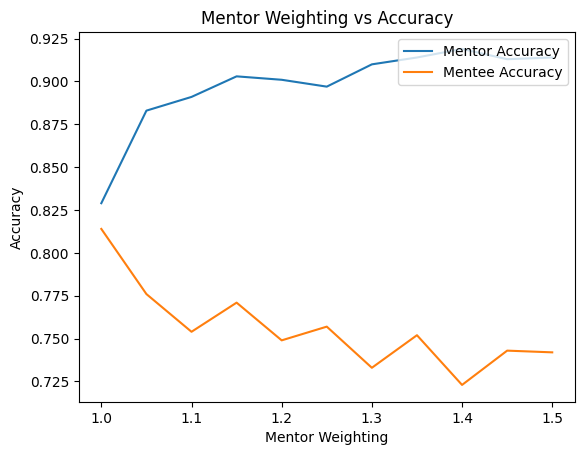

In [14]:
plt.plot(weights, mentor_data, label="Mentor Accuracy")
plt.plot(weights, mentee_data, label="Mentee Accuracy")
plt.legend(loc="upper right")
plt.xlabel("Mentor Weighting")
plt.ylabel("Accuracy")
plt.title("Mentor Weighting vs Accuracy")
plt.show()